#  Identifying Consumer Profiles in E-commerce: Customer Segmentation for the Online Store "Still Here for Now"

## Introduction

Segmentation of the audience is a key tool in the arsenal of marketers and data analytics specialists, enabling more precise adaptation of offerings to the needs and preferences of various consumer groups.

In the context of growing competition and the rapid development of e-commerce, personalized offers have become a necessary condition for attracting and retaining customers. Proper segmentation allows businesses to provide their clients with more tailored products, services, or marketing messages, directly impacting conversion rates.

This is particularly important in the digital space, where users expect a personalized approach, and customized offers increase their loyalty and purchase frequency.

The primary objective of this research is to provide a comprehensive analysis and recommendations to increase sales and customer loyalty for the "Still Here for Now" platform through segmented marketing.

The outcome of our study will be a ready-to-use informational platform for creating targeted advertising campaigns, helping to boost sales, retain customers, and improve key business metrics. To achieve this, we will take the following steps:

  - Conduct exploratory data analysis to identify patterns in customer purchases.
  - Define customer segments based on their purchase history, focusing on product categories.
  - Formulate and test statistical hypotheses about differences between the identified segments.
  - Develop recommendations for:
    - A more effective marketing strategy. Based on the analysis of customer segments, we will provide recommendations on which customers to target, when to send promotional offers, and which product categories to focus on.
    - A sales growth strategy. We will propose ways to increase the volume of products sold within each segment.
    - A loyalty enhancement strategy. We will suggest methods to improve customer retention for different segments.

To achieve the stated objectives, we have the dataset ecom_dataset_upd.csv at our disposal, which describes transactions for the home goods online store "Still Here for Now." The dataset includes the following columns:

    - date — the date of the order;
    - customer_id — the customer identifier;
    - order_id — the order identifier;
    - product — the product name;
    - quantity — the quantity of the product in the order;
    - price — the price of the product.

Before starting the research, we will import the necessary libraries and create functions to be used in the project.

In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import re
import pymorphy2

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.multitest import multipletests

[nltk_data] Downloading package stopwords to C:\Users\Артемий
[nltk_data]     Иванилов\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def primary_analysis(df):
    
    display("Information about the dataframe:")
    display(df.info())
    
    display("\nFirst 5 rows of the dataframe:")
    display(df.head())
    
    display("\nDescription of numerical columns:")
    display(df.describe())
    
    display("\nNumber of duplicate entries in the dataset:")
    display(df.duplicated().sum())

    display("\nNumber of missing values in the dataset:")
    display(df.isna().sum())
    
    display("\nFrequency distributions for categorical columns:")
   
    for column in df.select_dtypes(include=['object', 'category']).columns:
        display(f"\nColumn '{column}':")
        display(df[column].value_counts())

In [4]:
def data_loss(df, df_raw, column_name='name'):
    # Absolute loss
    loss_absolute = df_raw[column_name].count() - df[column_name].count()

    # Relative loss percentage
    loss_relative = 100 - (df[column_name].count() / df_raw[column_name].count() * 100)
    loss_relative = round(loss_relative, 2)

    # Convert to string and add '%' symbol
    loss_relative = str(loss_relative) + '%'

    display(f'Absolute data loss in column {column_name}: {loss_absolute}')
    display(f'Relative data loss in column {column_name}: {loss_relative}')

In [5]:
def aggregate_weekly_data(df):
    aggregated_data = df.groupby(['date', 'category']).agg(
        purchases=('order_id', 'nunique'), 
        sales=('sales', 'sum')
    ).reset_index()
    
    aggregated_data['week'] = aggregated_data['date'].dt.to_period('W').apply(lambda r: r.start_time)
    
    weekly_data = aggregated_data.groupby(['week', 'category']).sum().reset_index()
    
    return weekly_data

## Data Preprocessing

In data preprocessing, we will prepare the data for further analysis.

### Introduction to Data

First, let's load the data.

In [6]:
try:
    df = pd.read_csv('/datasets/ecom_dataset_upd.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

In [7]:
# We will also define a variable to calculate the data loss indicator

try:
    df_raw = pd.read_csv('/datasets/ecom_dataset_upd.csv')
except:
    df_raw = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

Let's get acquainted with the main characteristics of the data using the primary_analysis() function.

We will immediately introduce a new column — 'sales', where we multiply the price by the quantity of products sold. This variable will be used for analyzing outliers in the purchase receipt.

In [8]:
df['sales'] = df['quantity'] * df['price']

In [9]:
primary_analysis(df)

'Information about the dataframe:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
 6   sales        7474 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 408.9+ KB


None

'\nFirst 5 rows of the dataframe:'

,date,customer_id,order_id,product,quantity,price,sales
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0


'\nDescription of numerical columns:'

,date,order_id,quantity,price,sales
count,7.474000e+03,7474.000000,7474.000000,7474.000000,7474.000000
mean,2.018913e+09,49449.884265,2.362858,478.737501,716.877765
std,4.278878e+05,32679.642404,14.500497,901.615895,7939.831129
min,2.018100e+09,12624.000000,1.000000,9.000000,9.000000
25%,2.019022e+09,14833.000000,1.000000,97.000000,120.000000
50%,2.019051e+09,68768.000000,1.000000,135.000000,164.000000
75%,2.019063e+09,71257.750000,1.000000,439.000000,614.000000
max,2.020013e+09,112789.000000,1000.000000,14917.000000,675000.000000


'\nNumber of duplicate entries in the dataset:'

np.int64(0)

'\nNumber of missing values in the dataset:'

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
sales          0
dtype: int64

'\nFrequency distributions for categorical columns:'

"\nColumn 'customer_id':"

customer_id
1d6c8c1f-a799-4418-9af2-1ded47d7a85c    888
db77c238-3c80-4032-9e3c-c30a43f4a650    203
c971fb21-d54c-4134-938f-16b62ee86d3b    144
3d5fef90-4a65-4a7e-84cf-010eba7b038d     90
42d3cb27-6519-4627-9b4a-5aa8ee600203     63
                                       ... 
dea8ce52-7121-4451-8f88-e9ca2f947a5c      1
721c933c-ef2d-4ee4-91d1-424e8849a332      1
14cc96d3-7d14-4e84-9c15-76e57b642c72      1
c4575235-22e1-4552-8282-34ef61607d92      1
1bbf772b-3027-44ea-af8a-e66c17c08c2e      1
Name: count, Length: 2451, dtype: int64

"\nColumn 'product':"

product
Рассада Кабачка сорт Зебра кассета 6 шт E6                                                79
Рассада Кабачка сорт Золотинка кассета 6 шт E6                                            78
Рассада Кабачка сорт Белогор кассета 6 шт E6                                              77
Пеларгония розебудная Red Pandora укорененный черенок                                     77
Рассада Кабачка сорт Аэронавт, кассета по 6шт                                             76
                                                                                          ..
Муляж Лимон мини на магните                                                                1
Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 см алюминиевая с лотком для инструментов     1
Контейнер для мусора FLIP BIN CURVER 25 л графитовый 02171-686-00                          1
Муляж Лимон, желтый, 9 см, полиуретан, Fancy Fair/ff NM90                                  1
Муляж Перец, красный, 10 см, полиуретан, Fancy Fair/ff RP8    


The study involves data from 7,474 transactions of an online store. At first glance, the dataframe does not contain any rows with missing values, and the column names are correct.

The date column contains 7,474 non-null values in the int64 format. However, given the nature of the data, it is recommended to convert it to the datetime64 format. This change will be made in the next step of the analysis.

It would be incorrect to trim outliers in the quantity and price columns, as this would result in the loss of the most expensive items from the analysis and reduce the number of transactions. Outliers should be examined based on the total purchase amount, with their boundaries calculated using the interquartile range (1.5 * IQR). Work with anomalous values will continue in the following sections of data preprocessing.

There are no exact duplicates in the dataset, but partial or implicit duplicates cannot be ruled out. This issue will be addressed in the later stages of data preprocessing.

As for the categorical columns, there are already some interesting observations that will be further explored in the exploratory data analysis. For example:

- The top-5 customers account for 18.5% of all transactions. Notably, customer 1d6c8c1f-a799-4418-9af2-1ded47d7a85c alone accounts for nearly 12% of all purchases.
- The top-5 products include 4 different types of seedlings, 3 of which are zucchini seedlings of various varieties.

In other respects, the data appears normal. Let's take these observations and move on to the data preprocessing phase, where we will:

- Examine missing values in more detail
- Change the data types to the appropriate ones
- Analyze duplicates further
- Handle outliers
- Add a column for product categories
- Assess data loss in case rows need to be deleted from the dataframe

### Missing Values

A superficial check using the df.isna().sum() method showed that there are no missing values in the data. The description of numerical and categorical columns also confirms the absence of gaps in the data. As a final check, let's verify if there are any special characters such as "N/A", "NULL", "NA", etc., that may represent missing values in our dataset.

In [10]:
df[df.isin(['N/A', 'NA', 'null', 'NULL', 'none', 'None'])].sum()

date           0.0
customer_id      0
order_id       0.0
product          0
quantity       0.0
price          0.0
sales          0.0
dtype: object

There are no such values, meaning we have the complete data.

### Data Type Alignment

We will change the data type of the date column from int64 to datetime64.

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7474 non-null   datetime64[ns]
 1   customer_id  7474 non-null   object        
 2   order_id     7474 non-null   int64         
 3   product      7474 non-null   object        
 4   quantity     7474 non-null   int64         
 5   price        7474 non-null   float64       
 6   sales        7474 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 408.9+ KB


In [13]:
df.head()

,date,customer_id,order_id,product,quantity,price,sales
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0


All the other data types are in place, so we can move on. 

### Duplicates

Based on the analysis above, we can conclude that there are no exact duplicates in the data. However, let's check for partial duplicates by trying to find matches based on the fields 'customer_id', 'order_id', and 'product'.

In [14]:
df[df.duplicated(subset=['customer_id', 'order_id', 'product'], keep='first')].head(60)

,date,customer_id,order_id,product,quantity,price,sales
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0,1409.0
126,2018-10-07 17:00:00,ce0e0c29-8c8b-4714-84bd-80957224d4cf,68557,Сумка-тележка хозяйственная Gimi Market синяя,1,1874.0,1874.0
147,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"Таз пластмассовый 15,0 л пищевой овальный ""Ekk...",1,209.0,209.0
148,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"Таз пластмассовый 18,0 л пищевой (Иж), 1404047",1,194.0,194.0
149,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"Таз пластмассовый 20,0 л пищевой (Минеральные ...",1,277.0,277.0
150,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"Таз пластмассовый 24,0 л пищевой круглый (Иж),...",1,239.0,239.0


An interesting pattern can be found — the customer with ID ffaeab76-3a8d-49ee-860f-17273b2fc8a2 bought the same basin at different times, but the same order_id was assigned. Clearly, there is an error here — it can be assumed that when a new product is added, the old one might get duplicated. This is confirmed not only by the matching order_id, but also by the fact that the product quantity and price are identical. We will remove the duplicate rows.

In [15]:
df = df.drop_duplicates(subset=['order_id', 'customer_id', 'product'])

In [16]:
data_loss(df, df_raw, column_name='date')

'Absolute data loss in column date: 1886'

'Relative data loss in column date: 25.23%'

Duplicate transactions accounted for 25% of the total data. We can move on — let's take a look at the outliers.

###  Outliers and Anomalous Values

It would be incorrect to trim outliers in quantity and price, as this would result in losing the most expensive items and larger transactions from the analysis. Outliers should be evaluated based on the total purchase amount. Their boundaries are calculated using the interquartile range (1.5 * IQR).

In [17]:
df['bill'] = df.groupby('order_id')['sales'].transform('sum')
df

,date,customer_id,order_id,product,quantity,price,sales,bill
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,1037.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,1037.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,1037.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,1037.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,1037.0
...,...,...,...,...,...,...,...,...
7469,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38.0,76.0,76.0
7470,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0,869.0,869.0
7471,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354.0,354.0,354.0
7472,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128.0,128.0,128.0


In [18]:
unique_orders = df[['order_id', 'bill']].drop_duplicates()
unique_orders

,order_id,bill
0,68477,1037.0
7,68479,824.0
8,68478,269.0
9,68480,674.0
10,68483,820.0
...,...,...
7469,104002,76.0
7470,107336,869.0
7471,106336,354.0
7472,102002,128.0


In [19]:
min_val = unique_orders['bill'].min()
q1 = unique_orders['bill'].quantile(0.25)
median = unique_orders['bill'].mean()
q3 = unique_orders['bill'].quantile(0.75)
max_val = unique_orders['bill'].max()

In [20]:
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

In [21]:
display(f"Minimum value (min): {min_val}")
display(f"25th percentile (Q1): {q1}")
display(f"Median (50%): {median}")
display(f"75th percentile (Q3): {q3}")
display(f"Maximum value (max): {max_val}")
display(f"IQR: {iqr}")
display(f"Lower bound for outliers: {lower}")
display(f"Upper bound for outliers: {upper}")

'Minimum value (min): 9.0'

'25th percentile (Q1): 194.0'

'Median (50%): 1317.0336315440688'

'75th percentile (Q3): 1274.0'

'Maximum value (max): 675000.0'

'IQR: 1080.0'

'Lower bound for outliers: -1426.0'

'Upper bound for outliers: 2894.0'

We will handle outliers in the bill column by removing values that fall outside the lower and upper bounds for outliers.

In [22]:
unique_orders[unique_orders['bill'] >= upper].sort_values(by='bill')

,order_id,bill
2308,70718,2915.0
3195,14698,2922.0
346,68709,2923.0
57,68508,2924.0
2125,70552,2924.0
...,...,...
1299,69504,32718.0
1022,69156,33680.0
1518,69830,47385.0
5071,71668,49432.0


In [23]:
df[df['order_id'].isin([71668, 71743])]

,date,customer_id,order_id,product,quantity,price,sales,bill
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0,49432.0
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0,675000.0


All orders exceeding the upper bound for outliers appear normal — mostly large orders containing multiple product items in significant quantities. An example would be the order with order_id 69156. However, the two largest orders contain only one type of product, but in unusually large quantities: 334 hangers and 1000 plungers. This is highly atypical and even anomalous compared to other purchases, so these can be considered outliers and excluded from the dataset.

In [24]:
df = df[~df['order_id'].isin([71668, 71743])]

It is also worth checking for orders placed by more than one customer — such orders are incorrect and should be deleted.

In [25]:
order_multiple_customers = df.groupby('order_id')['customer_id'].nunique()
incorrect_oreder_id = order_multiple_customers[order_multiple_customers > 1].index
incorrect_oreder_id

Index([14872, 68785, 69283, 69310, 69345, 69410, 69485, 69531, 69833, 70114,
       70542, 70631, 70726, 70808, 70903, 70946, 71054, 71226, 71461, 71480,
       71542, 71571, 71648, 71663, 72188, 72778, 72790, 72845, 72950],
      dtype='int64', name='order_id')

In [26]:
df = df[~df['order_id'].isin(incorrect_oreder_id)]

In [27]:
data_loss(df, df_raw, column_name='date')

'Absolute data loss in column date: 1954'

'Relative data loss in column date: 26.14%'

After all the manipulations, the total data loss is 26%.

### Adding Product Categories

Data Preparation Steps:

- Converting text to lowercase.
- Tokenization (representation as a list of words) or removal of punctuation/numbers/stopwords (particles, conjunctions, prepositions).

In [28]:
df['product'] = df['product'].str.lower()

After analyzing the cleaned product names, we can identify 6 categories:

- Flowers
- Vegetables and Fruits
- Garden Supplies
- Textile and Decor
- Household Goods
- Kitchenware

For each category, we will select key words, based on which each item will be categorized:

In [29]:
categories = { 
    'Flowers': [
        'радермахер', 'хризолидокарпус лутесценс', 'циперус зумул', 'шеффлера лузеана', 'хлорофитум',
        'цикламен', 'глоксиния', 'азалия индик биколор', 'гортензия микс', 'хризантема космо микс', 
        'мирт', 'бегония', 'адиантум лиза', 'каланхий каландив', 'антуриум', 'фиалка', 'гербер', 
        'душица', 'лаванда', 'аспарагус', 'афеляндр', 'сантолина', 'иссол лекарственный', 'артифемизия',
        'пеларгония', 'петуния', 'калибрахоа', 'роза', 'эвкалипт', 'кампанула', 'колокольчик карпатский', 
        'хризантема', 'бальзамин', 'фаленопсис', 'дендробиум', 'калла', 'георгин', 'гортензия',
        'настурция орхидный пламя', 'гвоздик', 'шалфей', 'тюльпан', 'незабудка', 'флокс', 
        'алиссума', 'пуансеттия', 'вербена', 'соланум', 'спатифиллум', 'мединилла магнифика', 
        'виола', 'крассула', 'фиттония', 'примула', 'бархатцы', 'подсолнечник', 'годеция', 
        'эшшольция', 'анемон', 'камнеломка', 'георгин', 'астр альпийский', 'змееголовник', 
        'импатиенс', 'цинерария', 'камнеломка', 'лантан', 'аквилегия', 'вероника', 'вербейник', 
        'рудбекия', 'бадан', 'гаилардиа', 'монарда', 'завёртка', 'клён', 'нивянник ромашка', 
        'овсянница', 'гаилардиа крупноцветковый', 'рудбекия тайгера', 'вероника колосковый', 
        'камнеломка тенистый', 'солидаго', 'фикус', 'капроновый', 'хоста', 'сциндапсус', 
        'фиксатор', 'калатея микс', 'мимоза стыдливый', 'замиокулькас', 'диффенбахий камилла', 
        'фуксия', 'камнеломка тенистый', 'антуриум', 'мирт', 'гортензия', 'тюльпан', 'осина', 
        'нефролепис бостон', 'гиацинт луковица', 'гиацинт', 'платикодон', 'петуния', 
        'девичий виноград', 'декабрист', 'физостегия вергинский', 'папоротник', 'монарда гибридный', 
        'вербейник монетчатый', 'котовник', 'лилейникнуть', 'папоротник страусникнуть', 
        'смолёвка звёздный взрыв', 'астр альпийский микс', 'камнеломка арендс', 'буддлей', 
        'георгин', 'эпипремнум ауреум', 'алансон','комнатный','юкка нитчатый','многолетний тимьянчабрец',
        'эхеверие перл нюрнберг','нолин цветной керамик','аптения','новогодний дерево сербский',
        'пуансеттие','полка ньюйорк правый белыйголуба','бакоп','бакоп мегакрупный','базилик овощной арарат',
        'колокольчик персиколистный','лобелия', 'лобелия регатта микс','однолетний табак душистый',
        'карниз ванная виогод раздвижной кольцо','эхеверие микс','тимьян','чабёр','зверобой продырявить оптимист',
        'базилик пурпурный звезда','базилик смесь зелёный','гардения','кофе арабика','алоэ вера',
        'календула бронзовый красавица','полка белыйчрный','шеффлера голд капелла','фатсия японский',
        'эхинокактус грузонь','полка токио чрный','цинния ацтек бургунди биколор',
        'цинния хаага мехико','круглый водолей', 'суккулента микс', 'кориандр', 'круглый', 'иссоп лекарственный', 
        'набор свереть дерево','молодило микс', 'мелисса лекарственный', 'розмарин', 'альбук спиралиса фризлсизлый', 
        'артемизия полынь горький', 'петлястрела рыбинск','калоцефалус брауни крашеный осенний микс', 
        'каллуна гарден герлс трехцветной', 'капсикума сальса оранжевый', 'настурция драгоценность вишневорозовый', 'календула пинк сюрпрайза', 'кореопсис толл',
        'лапчатка огненный пламя', 'гиностемма укоренить черенок', 'канадский коник нидерланды', 'кипарисовик лавсон элвудить нидерланды', 'новогодний дерево канадский коник', 'новогодний дерево канадский коник ведёрко',
        'петлить рояльный оксид', 'скиммия японский рубелла', 'розмарин', 'полка лондон', 'овощ мясо', 'петлить рояльный цинк',
        'азалия индик', 'полка берлин чрный', 'кодонант укоренить черенок', 'гимнокалициум микс', 'калатея крокат', 'полка мадрид белыйчрный штука штука',
        'крокус луковица', 'седума почвопокровный смесь окраска', 'азалия индик', 'карниз ванная алюминий хром', 'полка барселона', 'тортница',
        'базилик зелёный тонус', 'лавр', 'эхинацея микс', 'ясколка войлочный', 'розмарин', 'базилик зелёный тонус',
        'энотера миссурийский золотой', 'урнапепельница стать хоббик', 'цитрофортунелла кумквата штамбовый', 'пеперомия', 'календула суприма', 'цинния коралловый красавица',
        'цинния оранжевый король', 'базилик застольный', 'настурция лунный свет', 'однолетний астр', 'мускари луковица', 'однолетний тагетис мелкоцветковый',
        'однолетний циния', 'муррайя', 'кореопсис золотой маяк', 'однолетний портулак', 'однолетний газаний', 'базилик зелёный тонус',
        'кориандр стимул раннеспелый штука', 'однолетний циния', 'однолетний целозия метельчатый', 'джункус пенсила грасс', 'драцена фрагранс компакт', 'однолетний львиный',
        'однолетний сальвия', 'седума почвопокровный смесь окраска', 'хост микс', 'однолетний астр', 'однолетний циния', 'гайлардия крупноцветковый желтокрасный',
        'кореопсис золотой маяк', 'монард гибридный бергамо', 'однолетний астр', 'однолетний циния', 'полка мадрид белыйчрный штука штука', 'обувница квадро венга',
        'лапчатка травянистый', 'седума очиток видный', 'барвинок', 'молодило', 'пряный трава микс', 'бузульник пржевальский кленолистный',
        'седума почвопокровный смесь окраска', 'ясколка войлочный', 'лапчатка травянистый', 'небесный лазурь', 'ясколка войлочный', 'фатсия',
        'однолетний львиный', 'лавр нобилиса', 'лаватер монт блан', 'ванна оцинковать магнитогорск', 'небесный лазурь', 'базилик овощной пурпурный звезда штука среднеспелый',
        'базилик овощной тонус штука среднеспелый', 'валериан лекарственный кардиол штука', 'лавр', 'любисток удалец штука', 'монард', 'табак бордовый штука',
        'табак курительный юбилейный новый штука среднеспелый', 'базилик зелёный тонус', 'лавр', 'хамедорей', 'полка берлин чрный', 'сахарница фарфоровый',
        'полка барселона', 'полка торонто', 'розмарин', 'амариллис темнокрасный луковица', 'стейк', 'полка торонто',
        'полка италия белыйсерый', 'круглый', 'базилик застольный', 'эхеверие лила чин', 'сахарница фарфоровый', 'зверобой продырявить',
        'пахир акватик мультистем', 'полка торонто', 'подушка ассортимент', 'полка италия белыйсерый', 'полка пекин белыйчрный', 'лавр',
        'полка италия белыйсерый', 'литопс микс', 'настурция драгоценность вишневорозовый', 'круглый', 'кипарисовик лавсон элвудить нидерланды', 'хамедорей',
        'муррайя', 'базилик застольный', 'калатея крокат', 'азалия индик', 'калатея крокат', 'цитрофортунелла кумквата штамбовый',
        'полка берлин чрный', 'кореопсис золотой маяк', 'полка лондон', 'гиностемма укоренить черенок', 'молодило', 'круглый',
        'энотера миссурийский золотой', 'иссоп лекарственный', 'базилик овощной пурпурный звезда штука среднеспелый', 'базилик овощной тонус штука среднеспелый', 'азалия индик', 'базилик овощной тонус штука среднеспелый'    
    ],
    'Vegetables and Fruits': [
        'дыня', 'огурец', 'морковь', 'картофель', 'кабачок', 'баклажан', 'клубника', 
        'капуста', 'укроп', 'арбуз', 'томат', 'петрушка', 'сельдерей', 'горох', 'земляника', 
        'патиссон диск раннеспелый', 'патиссон оранжевый', 'салат рукол дикий', 'салат рукол сицилия', 
        'тыква крупноплодный лечебный', 'порей победитель', 'импатиенс гвинея микс', 'вигна', 
        'порей победитель', 'тыква', 'томат', 'патиссон', 'порей', 'морковь', 'баклажан'
    ],
    'Garden Supplies': [
        'сад', 'хранение', 'уборка', 'садовые принадлежности', 'секатор', 'лопата', 'грабли', 
        'опрыскиватель', 'рассада', 'почва', 'мульча', 'удобрение', 'практичный', 'долговечный', 
        'удобный', 'эффективный', 'сверлофреза', 'плечики', 'гаражный', 'крепёж', 'пружина', 
        'корыто', 'кашпо', 'скребок', 'тряпкодержатель', 'лопатка', 'инструменты', 'практичный', 
        'долговечный', 'удобный', 'эффективный', 'сверлофреза', 'садовые', 'сменный блок ролик', 
        'пьезозажигалка мультиискра', 'садовые принадлежности', 'секатор', 'инструменты', 
        'садовые принадлежности', 'гаражный', 'крепёж', 'секатор', 'сверлофреза', 'лопата', 
        'плечики', 'гаражный', 'удобрение', 'практичный', 'удобный', 'эффективный', 'лопата', 
        'удобный', 'практичный', 'гаражный', 'многофункциональный', 'удобный', 'удобрение', 
        'гаражный', 'практичный', 'практичный', 'удобный', 'эффективный', 'рассада', 
        'почва', 'удобрение', 'практичный', 'лопата', 'практичный', 'инструменты', 
        'удобный', 'секатор', 'удобный', 'удобрение', 'секатор', 'удобрение', 
        'лопата', 'эффективный', 'инструменты', 'практичный', 'секатор', 'удобный', 
        'удобный', 'удобрение', 'секатор', 'садовые принадлежности', 'опрыскиватель', 
        'практичный', 'сад', 'крепёж', 'практичный', 'лопата', 'лопата', 'удобный', 
        'удобный', 'удобрение', 'удобрение', 'лопата', 'лопата', 'практичный', 'удобрение', 
        'секатор', 'удобрение', 'удобрение', 'инструменты', 'удобрение', 'лопата', 
        'удобрение', 'лопата', 'садовые принадлежности', 'удобрение', 'удобрение', 
        'секатор', 'удобрение', 'удобрение', 'удобрение', 'лопата', 'удобрение', 'удобрение', 
        'удобрение', 'лопата', 'удобрение', 'удобрение', 'удобрение', 'лопата', 
        'удобрение', 'удобрение', 'удобрение', 'удобрение', 'лопата', 'удобрение'
    ],
    'Textile and Decor': [
        'коврик', 'скатерть', 'плед', 'текстиль', 'хлопок', 'покрывало',
        'наволочка', 'шторы', 'декор', 'уют', 'мягкий', 'стеганый',
        'стильный', 'рисунок', 'красивый', 'оригинальный', 'ковровый', 'штора',
        'ковёр', 'ковр', "одеяло",'халат','полотенце','сушилка', 'бельё', 'потолочный', 'напольный', 'настенный', 
        'складывающийся', 'переносной', 'компактный', 'быстрая сушка',
        'место для сушки', 'стирка', 'хранилище', 'практичный', 'удобный', 
        'эффективный', 'стильный', 
        'стеллаж обувь светлый', 'стеллаж обувь венга','мятый','муляж', 'фрукты', 'овощи', 
        'полиуретан', 'искусственный', 'реалистичный',
        'декор', 'интерьер', 'выставочный', 'витрина', 'кулинария', 'обучение',
        'моделирование', 'декоративный', 'праздничный', 'стильный', 
        'искусственные фрукты', 'искусственные овощи'
    ],
    'Household Goods': [
        'сумка', 'тележка', 'мусор', 'контейнер', 'корзина', 'организация',
        'хранение', 'упаковка', 'ведро', 'многофункциональный',
        'удобный', 'практичный', 'уход', 'чистота', 'стильный', 'эффективный',
        'подставка', 'прищепка', 'швабра', 'крышка', 'пыль', 'способы',
        'средство', 'бензин', 'гладильный', 'щётка', 'щеткаутюжок', 'штанга', 
        'щеткасмётка', 'мыло', 'зубной паста', 'унитазный', 'перчатка', 
        'стремянка', 'бутылка', 'стяжка', 'крем', 'подрукавник', 'пилообразный', 
        'подрукавник', 'бидон', 'хлебница', 'миска варение алюминиевый', 
        'ведро', 'ящик почтовый металлический ушко навесный замок домик', 
        'туалет', 'крем',"весы", "шуруповерт","сварка","плита","фоторамка", 'косметь',
        'кузьмич','сидение','вантуз','комод','ключница','ваза','складный детский пожарный машинка',
        'ножи','овальный','пластик','полимербыт','ручка','короб','смётка','паста',
        'тряпка','электрика','соль','штангенциркуль','пиретрум','насос','электрошнур',
        'пробка','кисточка','ополаскиватель','электроштопор','орехоколка','маска','ткань',
        'сверло','универсальный','ковш','лоток','лантан','шнур','батарейка','обувь','решётка',
        'кипятильник'
    ],
    'Kitchenware': [
        'кухонный', 'столовый', 'сталь', 'посуда', 'кухонные принадлежности',
        'кастрюли', 'сковородки', 'столовые приборы', 'сервировка',
        'утварь', 'принадлежности', 'аксессуары', 'гаджеты', 'дизайн',
        'практичность', 'удобство', 'минисковорода', 'сковорода', 'чайник', 
        'противень', 'овощеварка', 'тарелка', 'кружка', 'чехол', 
        'фужер', 'кувшин', 'банка', 'маслёнка', 'салатник', 'салфетка', 
        'салфетница', 'стакан', 'ложка', 'лопатка', 'толкушка', 'веник', 
        'гладильный', 'удобный', 'вешалка', 'крючок', 'чистка', 'прищепка', 
        'влажный', 'чистящий', 'светильник', 'стиральный', 'пена', 'пищевой', 
        'подголовник', 'угольник', 'линейка', 'крепёж', 'пружина', 'лестница',
        'строительный', 'губка', 'ножеточка', 'гладильный', 'щётка', 
        'щеткаутюжок', 'дорожный', 'хранилище', 'корыто', 'чистящее', 
        'антижир', 'банк', 'пластхозторг',
        'сотейник алюминиевый керамический покрытие керамика',
        'кастрюля эмалировать хозлэнд', 'кастрюля круглый серый чугунный',
        'термос стеклянный колба темнозелёный', 'соковыжималка цитрусовый',
        'термометр уличный оконный', 'тёрка', "набор чайный", "миксер", "утюг", "мясорубка", "кастрюля",
        "разделочная доска", "форма выпечки", "термос", "коробка", "кофр", "ящик",
        "упаковка","контейнер", "термометр", "мыльница", "венчик", "сито",'вилка','бокал',
        'форма','измельчитель','пресс чеснок','картофелемялка','сетка глажение',
        'совка','разделочный доска','чайный набор','блюдце','разделочный',
        'просеиватель','алюминиевый','нержавеющий','медь','полипропиленовый','керамика',
        'бульонница','нож','ёмкость','миска','блюдо','соковарка','скалка','отделитель'
    ]
}      

In [30]:
def assign_category(description):
    for category, keywords in categories.items():
        if any(keyword in description for keyword in keywords):
            return category
    return 'Not Defined'

In [31]:
df['category'] = df['product'].apply(assign_category)

Let's check how the categories are distributed and whether there are any items with a specific category:

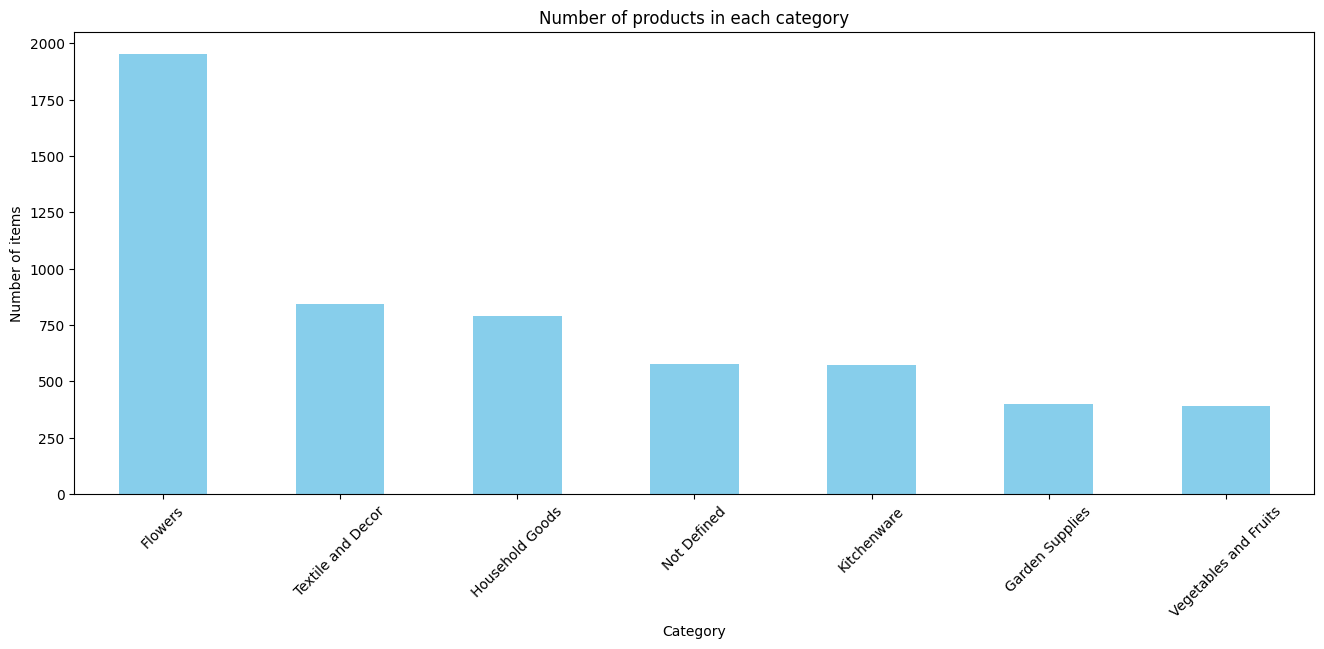

"Products with category 'Not Defined':"

,date,customer_id,order_id,product,quantity,price,sales,bill,category
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,1037.0,Not Defined
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d-12 см h-25-35 см,1,134.0,134.0,1037.0,Not Defined
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,3299.0,3299.0,Not Defined
61,2018-10-02 21:00:00,29a514f5-a27e-4939-85d5-874a0c3f7a2c,68510,суккулент микс d-5 см,1,74.0,74.0,193.0,Not Defined
62,2018-10-02 21:00:00,29a514f5-a27e-4939-85d5-874a0c3f7a2c,68510,эхеверия перл фон нюрнберг d-7 см,1,119.0,119.0,193.0,Not Defined
...,...,...,...,...,...,...,...,...,...
7429,2020-01-24 10:00:00,6716fe16-7871-47d5-a0d2-86691f8d46de,109302,гладильная доска sarayli new elegant 125x45 см,1,2549.0,2549.0,2549.0,Not Defined
7430,2020-01-24 16:00:00,1f502315-d58f-401c-8ba2-88b16e53d0b3,110414,гладильная доска hausmann classic mono 120x38 ...,1,2399.0,2399.0,2399.0,Not Defined
7450,2020-01-27 14:00:00,ae036d1b-b1d5-41e4-8c85-d2bd1b0b4e18,101880,настурция орхидное пламя 5 шт 4650091480692,1,14.0,14.0,14.0,Not Defined
7454,2020-01-28 11:00:00,ea0d1348-249e-4aff-9149-599eb6d98dec,106547,настурция орхидное пламя 5 шт 4650091480692,1,14.0,14.0,14.0,Not Defined


In [32]:
category_counts = df['category'].value_counts()

plt.figure(figsize=(16, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of products in each category')
plt.xlabel('Category')
plt.ylabel('Number of items')
plt.xticks(rotation=45)
plt.show()

uncategorized_items = df[df['category'] == 'Not Defined']
display("Products with category 'Not Defined':")
display(uncategorized_items)

In [33]:
uncategorized_items['product'].tolist()

['комнатное растение в горшке алое вера, d12, h30',
 'юкка нитчатая d-12 см h-25-35 см',
 'доска гладильная eurogold professional 130х48 см металлическая сетка 35748w',
 'суккулент микс d-5 см',
 'эхеверия перл фон нюрнберг d-7 см',
 'набор кружек для пива гамбург 2шт 500мл, h5072, luminarc, россия',
 'дозатор для мыла hausmann белый hm-b0194r-2',
 'ковер придверный "multy rus" 120х180см., коричневый, рр214/07034',
 'перчатки латексные № 3 для дома утолщенные, rozenbal, r105628',
 'гладильная доска gimi jean green line 107х30 см',
 'комнатное растение в горшке алое вера, d12, h30',
 'нолина в цветной керамике d-7 см',
 'крепеж для пружины дверной, 1107055',
 'петля приварная гаражная d 14х90 мм с шаром, 1103003',
 'вкладыши для хранения посуды 2 шт d-38 cm marmiton, lg17056',
 'щетка для смахивания пыли 60 см разноцветная, burstenmann, 0528/0000',
 'стремянки colombo leonardo 3 ступени g300a03w черая 3649',
 'таз пластмассовый со стиральной доской (иж), 1404021',
 'щетка для посуды *ми

In [37]:
df = df[df['category'] != 'Not Defined']

According to the chart, the categorization has been successful — there are no items without a category. It can also be noted that the highest number of purchases was made in the "Flowers" category, with just over 2000 transactions. The next most popular categories were Household Goods, Textile and Decor, with 1000 transactions. Rounding out the top categories are "Vegetables and Fruits", "Kitchenware", and "Garden Supplies", each with about 500 transactions. In the next part of our study, we will dive deeper into the data analysis to better understand these trends.

## Exploratory Data Analysis

In the exploratory analysis, we will analyze the key metrics of the online store.

### Analysis of Purchase Distribution by Product Categories

Let's calculate the total number of purchases for each product category and use a bar chart for a clear comparison of the number of purchases by category.

Let's start by creating a color dictionary so that the categories have the same color throughout the project.

In [38]:
category_colors = {
    'Flowers': '#4CAF50',
    'Household Goods': '#303F9F',
    'Textile and Decor': '#FFD54F',
    'Vegetables and Fruits': '#E64A19',
    'Kitchenware': '#ff0ecf',
    'Garden Supplies': '#9C27B0'
}

In [39]:
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
category_counts

,category,count
0,Flowers,1953
1,Textile and Decor,845
2,Household Goods,788
3,Kitchenware,571
4,Garden Supplies,398
5,Vegetables and Fruits,389


In [40]:
colors = [category_colors[category] for category in category_counts['category']]

C:\Users\Артемий Иванилов\AppData\Local\Temp\ipykernel_23240\3635942504.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='count', data=category_counts, ax=axs, palette=colors)


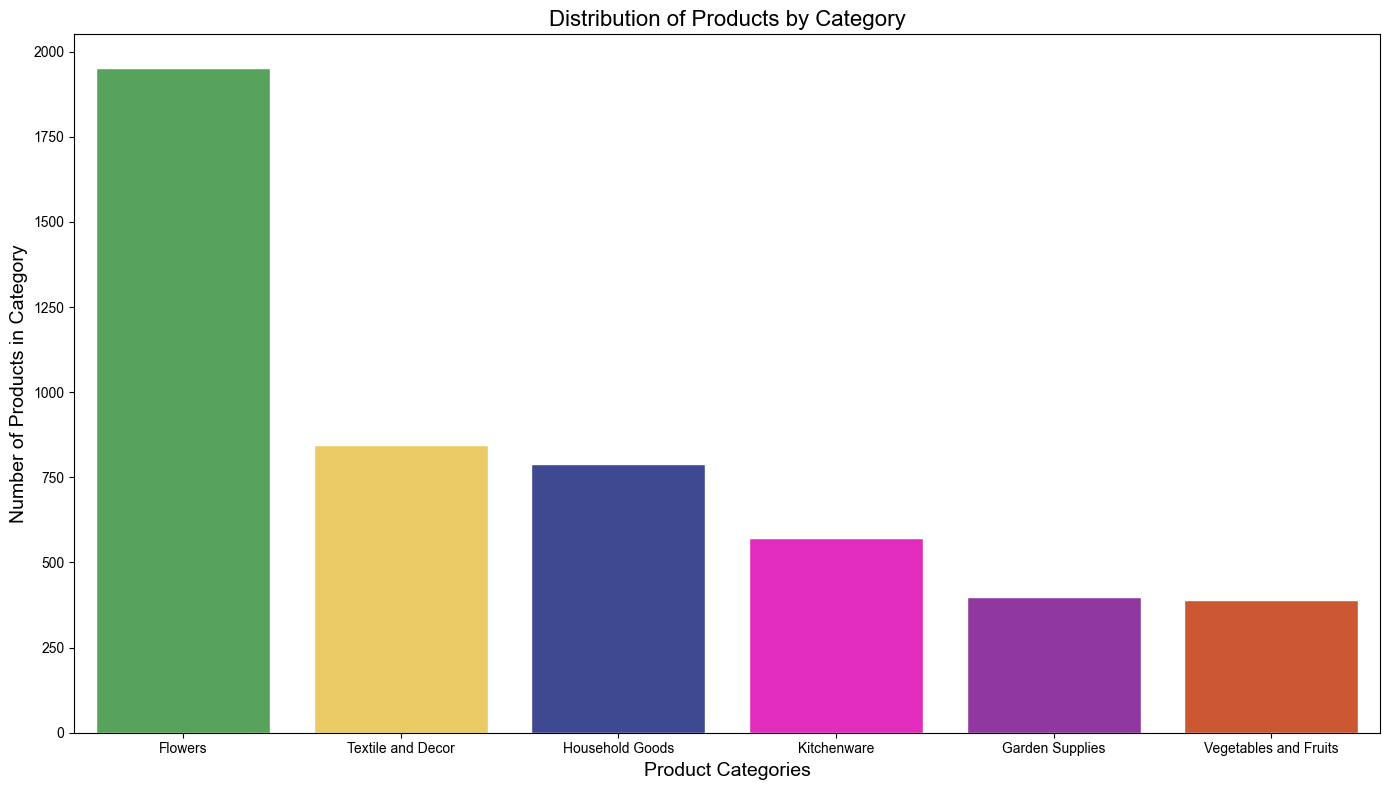

In [41]:
fig, axs = plt.subplots(figsize=(14, 8))
sns.set_palette('pastel')
sns.set_style('white')
sns.barplot(x='category', y='count', data=category_counts, ax=axs, palette=colors)

axs.set_title("Distribution of Products by Category", fontsize=16)
axs.set_xlabel("Product Categories", fontsize=14)
axs.set_ylabel("Number of Products in Category", fontsize=14)

plt.tight_layout()
plt.show()

The highest number of purchases was made in the "Flowers" category, with just 2256 transactions. The next most popular categories were Household Goods, Textile and Decor, with 1017 and 997 transactions, respectively. Closing the top categories are "Vegetables and Fruits" and "Kitchen Utensils" with 564 and 512 transactions. The category with the fewest purchases is "Garden Accessories" with 240 transactions.

### Seasonality for Product Сategories

Let's explore how the number of purchases and revenue for different product categories change over time. We will try to visualize this using a line chart. 

We will group the data by date and apply aggregation functions that will help us when building the charts.

In [41]:
aggregated_data = df.groupby(['date', 'category']).agg(
    purchases=('order_id', 'nunique'), 
    sales=('sales', 'sum') ).reset_index()

We will group the data by date and apply aggregation functions that will help us when building the charts.

In [42]:
aggregated_data['week'] = aggregated_data['date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_data = aggregated_data.groupby(['week', 'category']).sum().reset_index()

Finally, we build the line charts.

In [ ]:
plt.figure(figsize=(14, 8))

# Purchase Count Chart

plt.subplot(2, 1, 1)
for category in weekly_data['category'].unique():
    category_data = weekly_data[weekly_data['category'] == category]
    plt.plot(category_data['week'], category_data['purchases'], label=category,color=category_colors[category])
plt.title('Количество покупок по категориям')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.legend(loc='upper left')
plt.grid(True)

# Revenue Chart

plt.subplot(2, 1, 2)
for category in weekly_data['category'].unique():
    category_data = weekly_data[weekly_data['category'] == category]
    plt.plot(category_data['week'], category_data['sales'], label=category,color=category_colors[category])
plt.title('Выручка по категориям')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


We will analyze the charts for different categories:

- Kitchenware: The number of purchases and revenue show no distinct peaks in specific seasons. Kitchen items are purchased evenly throughout the year without a strong seasonal tie.

- Vegetables and Fruits: Revenue and the number of purchases rise sharply in March and May, likely linked to the beginning of planting seasons for various crops. There is also an increase in autumn (September-October), which may be associated with harvest season.

- Garden Supplies: There is a very pronounced seasonality—peaks are observed in spring (March-May), which is logical as it marks the start of the gardening season. There is also a slight increase in autumn, likely related to the end of the gardening season and preparation for winter, but it is much smaller than the spring peak.

- Textiles and Decor: The trend is less pronounced, but there are small rises in the winter period (December). This might be because textiles and decor are purchased for holiday preparation or as gifts for New Year celebrations.

- Household Goods: These items do not have distinct seasonality—similar to kitchenware, they are needed year-round.

- Flowers: There is a clear spike in purchases and revenue in early March, likely related to the start of the gardening season, along with slight increases in May and September, which may also be related to planting different crops. Summer and autumn show a decrease in buyer activity.

Now, let's highlight the specific seasons:

- March-May and September-October: "Vegetables and Fruits", "Garden Supplies", "Flowers"
- December: "Textiles and Decor"

### Analysis of the Dynamics of the Overall Average Check.

We will explore how the average check changes over time, both overall and for different product categories. We will calculate it by order_id on a weekly basis. For visualization, we will use a line chart.

Let's calculate the overall average check.

In [44]:
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
overall_average_bill = df.groupby('week')['bill'].mean().reset_index()
overall_average_bill = overall_average_bill.rename(columns={'bill': 'average_bill'})

In [ ]:
plt.figure(figsize=(14, 8))

# Graph of the overall average check dynamics

plt.plot(overall_average_bill['week'], overall_average_bill['average_bill'], label='Общий средний чек', color='orange')
plt.title('Общий средний чек')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

Let's take a look at the overall average check:

- The average check shows significant fluctuations, reaching peaks at the beginning and middle of the observed period. These fluctuations may be related to the seasonality of the products sold, such as "Vegetables and Fruits," "Flowers," and "Garden Supplies" in May-June 2019, and Christmas and New Year's purchases in November-December 2018.

### Analysis of Revenue for Product Categories and its Growth Dynamics.

We will examine how the total revenue of the online store changes over time, both overall and for different product categories. For visualization, we will use a cumulative chart.

In [ ]:
overall_sales = weekly_data.groupby('week')['sales'].sum().reset_index()
overall_sales['cumulative_sales'] = overall_sales['sales'].cumsum()
overall_sales

In [ ]:
plt.figure(figsize=(14, 8))

# Chart of the total cumulative revenue growth dynamics

plt.subplot(2, 1, 1)
plt.plot(overall_sales['week'], overall_sales['cumulative_sales'], label='Роста общей кумулятивной выручки', color='orange')
plt.title('Роста общей кумулятивной выручки')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка в миллионах')
plt.legend(loc='upper left')
plt.grid(True)

# Chart of the cumulative revenue growth dynamics for each category

plt.subplot(2, 1, 2)
for category in weekly_data['category'].unique():
    category_data = weekly_data[weekly_data['category'] == category]
    plt.plot(category_data['week'], category_data['sales'].cumsum(), label=category,color=category_colors[category])
plt.title('Роста кумулятивной выручки каждой категории')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка в миллионах')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [48]:
overall_sales_category = weekly_data.pivot_table(index='category', values='sales', aggfunc='sum').fillna(0)

In [ ]:
plt.figure(figsize=(14, 8))
colors = [category_colors[category] for category in overall_sales_category.index]
plt.pie(overall_sales_category['sales'], 
        labels=overall_sales_category.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=colors
)
plt.title("Общая выручка по категориям (в процентах)")
plt.show()

First, let's examine the overall cumulative revenue growth:

- There is a consistent and linear revenue growth, with an increase of half a million every two months. By the end of the analyzed period, at the beginning of 2020, the total revenue reaches 4 million rubles.

Now, let's look at the dynamics of cumulative revenue growth by category:

- Household goods show the most active and stable (linear) growth, increasing revenue by 250,000 rubles every two months. By the end of the period, the revenue of this category exceeds 1.5 million rubles, which accounts for 42% of the total revenue.
- Textiles and decor also show steady growth, though less pronounced compared to "Household goods". Ultimately, the revenue of this category reaches 1 million rubles, which accounts for 27% of the total revenue. The dynamics of this category are characterized by spikes in June and January, which correlate with changes in the average check.
- Flowers show steady, but less active growth, just shy of 750,000 rubles, which accounts for 16% of the total revenue. In the first half of 2019, growth rates were especially high, but by the end of the summer of 2019, growth slowed down, indicating the seasonal nature of this category.
- Kitchenware reaches nearly 500,000 rubles in revenue, accounting for 10% of the total revenue. The main growth occurs in the first half of 2019.
- Garden supplies show stable but weak growth, not reaching the 100,000 ruble mark, accounting for 3% of the total revenue.
- Vegetables and fruits round out the list. This category generates no revenue until April 2019, after which there is a brief growth until July 2019, then it levels off, generating no significant sales. The share of this category in total revenue is 2%, further emphasizing its seasonal nature.

### Analysis of Monthly Dynamics of Average Revenue per Customer 


In this section, we need to examine how the average revenue per customer changes over the weeks. This will allow us to assess customer loyalty and their activity during different periods. For visualization, we will use a line chart. 

To begin, let's update the weekly_data variable by adding customer_id and removing category.

In [50]:
aggregated_data = df.groupby(['date', 'category','customer_id']).agg(
    purchases=('order_id', 'count'), 
    sales=('sales', 'sum') ).reset_index()

In [51]:
aggregated_data['week'] = aggregated_data['date'].dt.to_period('W').apply(lambda r: r.start_time)

In [ ]:
weekly_data = aggregated_data.groupby(['week','customer_id']).sum().reset_index()
weekly_data

Let's group the data by weeks and count the number of unique users.

In [ ]:
weekly_customers = weekly_data.groupby('week')['customer_id'].nunique().reset_index(name='unique_customers')
weekly_customers

We will also group the data by weeks, but now by total sales.

In [ ]:
weekly_sales = weekly_data.groupby('week')['sales'].sum().reset_index()
weekly_sales

Let's join the two tables.

In [ ]:
weekly_summary = pd.merge(weekly_sales, weekly_customers, on='week')
weekly_summary['avg_sales_per_customer'] = weekly_summary['sales'] / weekly_summary['unique_customers']
weekly_summary

Now, let's build a line chart for the average revenue per customer per week.

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(weekly_summary['week'], weekly_summary['avg_sales_per_customer'], color='orange', marker='o', linestyle='-')
plt.title("Средняя выручка на одного покупателя по неделям")
plt.xlabel("Неделя")
plt.ylabel("Средняя выручка на покупателя")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Let's analyze the graph:

- The overall trend appears to be downward, accompanied by fluctuations of varying amplitudes. The period from November 2018 to February 2019 is marked by significant changes: values drop to 1000 and rise to 2500 within a month. Similar fluctuations are observed from April to June 2019. Subsequently, the amplitude of the fluctuations becomes less pronounced, but in October 2019, there is a sharp drop to 500, and this level is maintained until the end of the observation period. The causes of such fluctuations may include holidays (Christmas and New Year), seasonal factors (start of the gardening season), and the impact of promotional campaigns.

### Analysis of Purchase Frequency

The analysis of purchase frequency helps to determine how often customers return for purchases. A histogram would be the best visualization for this.

In [ ]:
purchase_frequency = df.groupby('customer_id')['order_id'].nunique()
purchase_frequency.sort_values()

In [ ]:
plt.figure(figsize=(14, 6))
plt.hist(purchase_frequency, bins=50, color='skyblue', edgecolor='black')
plt.title("Частота покупок клиентов")
plt.xlabel("Количество покупок")
plt.ylabel("Число клиентов")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))
plt.boxplot(purchase_frequency, vert=False, patch_artist=True)
plt.title("Распределение частоты покупок клиентов")
plt.xlabel("Количество покупок")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Let's analyze the graph:

- Distribution of values: Most of the values are concentrated around 1. This suggests that the majority of users made purchases only a minimal number of times, for example, 1-2 times.

- Anomalous data: Despite the prevalence of low values, there is a group of users who return much more frequently. For instance, a user with the identifier c971fb21-d54c-4134-938f-16b62ee86d3b returned 126 times. This indicates the presence of loyal customers or active participants who make frequent purchases.

## The main research questions

In this chapter, we will perform customer segmentation. The goal is to create three distinct groups of customers based on their behavior.

### Customer Segmentation using RFM analysis.

Customer segmentation will be conducted using the RFM method based on their purchase history. Three groups of customers will be identified: lost customers, inactive customers, and loyal customers. The method will be implemented through filtering, creating auxiliary columns, and assigning ranks.

First, let's define the last transaction date.

In [ ]:
df['date'].sort_values()

In [61]:
current_date = pd.to_datetime('2020-02-01')


We will re-group the data based on the three parameters that we will use for the RFM analysis:

- R (from recency) – determines how recent the transaction was. It shows how much time has passed since the last purchase. To calculate this, we will subtract the transaction date from the current_date.
- F (from frequency) – shows how often a customer makes a purchase. We will calculate this using the count function on the customer_id column.
- M (from monetary) – represents the total amount spent on the product. We will use the sum function on the sales column.

In [62]:
df_rfm = df.groupby('customer_id').agg({
    'date': lambda x: (current_date - x.max()).days, 
    'customer_id': 'count',  
    'sales': 'sum'  
}).rename(columns={'date': 'recency', 'customer_id': 'frequency', 'sales': 'monetary'})

In [ ]:
df_rfm

We use the rank method to assign ranks.

In [64]:
df_rfm['r_rank'] = df_rfm['recency'].rank(ascending=False, method='max').astype(int)
df_rfm['f_rank'] = df_rfm['frequency'].rank(ascending=True, method='min').astype(int)
df_rfm['m_rank'] = df_rfm['monetary'].rank(ascending=True, method='min').astype(int)

After ranking, we use pd.cut to divide the rank values into 3 categories, ranging from 0 to 2.

In [65]:
df_rfm['r_rank'] = pd.cut(df_rfm['r_rank'], bins=3, labels=[1, 2, 3]).astype(int)
df_rfm['f_rank'] = pd.cut(df_rfm['f_rank'], bins=3, labels=[1, 2, 3]).astype(int)
df_rfm['m_rank'] = pd.cut(df_rfm['m_rank'], bins=3, labels=[1, 2, 3]).astype(int)

In [ ]:
df_rfm

By summing all the ranks, we obtain the overall RFM_Score.

In [ ]:
df_rfm['rfm_score'] = 0.15 * df_rfm['r_rank'] + 0.28 * df_rfm['f_rank'] + 0.57 * df_rfm['m_rank']
df_rfm

We will use the distribution of customers into churned, inactive, and active based on the following source: https://timeweb.com/ru/community/articles/chto-takoe-rfm-analiz.

In [68]:
def segment_customer(score):
    if 2.5 < score <= 3:
        return 'Постоянные клиенты'
    elif 2 < score <= 2.5:
        return 'Неактивные клиенты'
    else:
        return 'Ушедшие клиенты'

In [69]:
df_rfm['rfm_segment'] = df_rfm['rfm_score'].apply(segment_customer)

In [ ]:
df_rfm

Now, let's transfer the segment information from the df_rfm dataset to the main dataset df.

In [71]:
df_rfm.drop(columns=['recency', 'frequency','monetary','r_rank','f_rank','m_rank','rfm_score'], inplace=True)

In [72]:
df = df.merge(df_rfm[['rfm_segment']], on='customer_id', how='left')

In [ ]:
df

### Description of the Obtained Segments.

Let's describe and compare the size of the segments, main product categories, average check, revenue, number and frequency of purchases, and customer loyalty (how often they return for new purchases).

For convenience, we will also create a color dictionary.

In [74]:
rfm_colors = {
    'Постоянные клиенты': '#77b41f',
    'Неактивные клиенты': '#101029',
    'Ушедшие клиенты': '#e34234',
}

#### Sizes of the Segments.


Let's start with the segment sizes.

In [ ]:
rfm_counts = df.groupby('rfm_segment')['customer_id'].nunique().reset_index()
rfm_counts.columns = ['rfm_segment', 'count']
rfm_counts

In [ ]:
colors = [rfm_colors[rfm_segment] for rfm_segment in rfm_counts['rfm_segment']]

fig, axs = plt.subplots(figsize=(18, 6))
sns.set_palette('pastel')
sns.set_style('white')
sns.barplot(x='rfm_segment', y='count', data=rfm_counts, ax=axs, palette=colors)

axs.set_title("Распределение клиентов по сегментам", fontsize=16)
axs.set_xlabel("Сегменты", fontsize=14)
axs.set_ylabel("Количество клиентов в сегметнах", fontsize=14)

plt.tight_layout()
plt.show()

- The largest segment is the churned customers - 1230.
- Next, we have inactive customers - 726.
- We also have loyal customers, totaling 456.

#### Main Product Сategories.

Now let's take a look at how product categories are distributed across different segments.

In [ ]:
segment_category_df = df.pivot_table(index='rfm_segment', columns='category', values='order_id', aggfunc='count').fillna(0)
segment_category_df = segment_category_df.sort_values(by='Цветы', ascending=True)
segment_category_df

In [ ]:
colors = [category_colors[category] for category in segment_category_df.columns]

sns.set_style('white')
sns.set_palette('pastel')

segment_category_df.plot(kind='barh', stacked=True, figsize=(18, 10), color=colors)

plt.title('Количество транзакций совершенных в ранзных категорий разными сегментами', fontsize=16)
plt.xlabel('Количество', fontsize=14)
plt.ylabel('Сегменты', fontsize=14)
plt.legend(title='Категория', fontsize=12)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.7) 

plt.tight_layout()
plt.show()

- Churned customers: The majority of transactions are in the "Flowers", "Textiles and Décor", and "Household Goods" categories. "Kitchenware" comes last. There are also small numbers of purchases in the "Vegetables and Fruits" and "Garden Supplies" categories.

- Inactive customers: These customers also made many purchases in the "Flowers" and "Household Goods" categories, but in different proportions—more flowers and fewer household goods, as well as in the "Textiles and Décor" category. A significant number of items were bought from the "Vegetables and Fruits" category, followed by "Kitchenware". "Garden Supplies" had the fewest purchases.

- Loyal customers: In general, loyal customers bought more items, and the proportions follow a similar trend to churned and inactive customers. The "Flowers" category stands out with significantly more purchases than the others. Next, "Household Goods", "Textiles and Décor", and "Vegetables and Fruits" are bought in roughly equal amounts. "Kitchenware" and "Garden Supplies" are at the bottom of the list.

To improve retention and engagement, efforts should focus on promoting the "Flowers", "Textiles and Décor", and "Household Goods" categories. These categories attract attention from churned and inactive customers and also generate interest from loyal buyers.

#### Average Сheck

Now let's take a look at the average check dynamics across different segments.

In [ ]:
aggregated_data = df.groupby(['date', 'rfm_segment']).agg(
    purchases=('order_id', 'nunique'), 
    sales=('sales', 'sum') ).reset_index()
aggregated_data

In [ ]:
aggregated_data['week'] = aggregated_data['date'].dt.to_period('W').apply(lambda r: r.start_time)
aggregated_data

In [ ]:
weekly_data = aggregated_data.groupby(['week', 'rfm_segment']).sum().reset_index()
weekly_data

In [ ]:
weekly_data['average_bill'] = weekly_data['sales']/weekly_data['purchases']
weekly_data

In [ ]:
plt.figure(figsize=(14, 8))

for rfm_segment in weekly_data['rfm_segment'].unique():
    rfm_segment_data = weekly_data[weekly_data['rfm_segment'] == rfm_segment]
    plt.plot(rfm_segment_data['week'], rfm_segment_data['average_bill'], label=rfm_segment, color=rfm_colors[rfm_segment])
plt.title('Динамика среднего чека для разнвых сегментов')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

- Loyal customers generally maintain higher average check values over time, although there are noticeable fluctuations, especially with a peak in early 2019 and another increase in mid-2019. After these peaks, the average check stabilizes but remains lower than before.

- Lost customers show a stable low average check, which also has a downward trend.

- Inactive customers demonstrate significant jumps in the average check dynamics, indicating the inconsistency of this segment. These fluctuations may be caused by spontaneous purchases related to promotions and discounts, as well as changes in the assortment and prices, suggesting that such customers do not have regular behavior and actively respond to temporary offers. It's also worth noting that the average check values don't stray too far from those of loyal customers, highlighting the importance of this segment.

Loyal customers provide the highest revenue, despite fluctuations in their average check, making them a valuable segment for the business. Lost customers show a decrease in spending before fully churning, which may indicate issues. Inactive customers have a low average check, indicating the need for targeted strategies for their re-engagement or their lower value. Specifically, loyal customers demonstrate higher average check values with noticeable fluctuations, including peaks in early and mid-2019. Lost customers maintain a stable low average check with a downward trend, while inactive customers exhibit significant jumps, indicating irregular purchasing behavior, but their average check is close to that of loyal customers, emphasizing the importance of this segment.

#### Revenue

In the same vein, let's look at the revenue.

In [ ]:
plt.figure(figsize=(14, 8))

for rfm_segment in weekly_data['rfm_segment'].unique():
    rfm_segment_data = weekly_data[weekly_data['rfm_segment'] == rfm_segment]
    plt.plot(rfm_segment_data['week'], rfm_segment_data['sales'].cumsum(), label=rfm_segment,color=rfm_colors[rfm_segment])
plt.title('Роста кумулятивной выручки каждой сегмента')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка в миллионах')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

- Loyal customers show steady growth in cumulative revenue throughout the period, with an increase of 250,000 every 2 months.

- Inactive customers follow the same trend as loyal customers, but their activity declines after the end of 2019 and stabilizes at a plateau. This suggests a need for re-engagement strategies for this segment.

- Churned customers have stable low revenue until the end of 2019, showing an increase of 250,000 every 6 months. After this period, this segment reduces its activity and reaches a plateau.

Loyal customers demonstrate consistent growth in cumulative revenue throughout the period, increasing by 250,000 every two months, confirming their value to the business. In contrast, inactive customers follow a similar trend but their activity begins to decline after the end of 2019 and stabilizes at a low level, highlighting the need for strategies to re-engage them. Churned customers show stable low revenue until the end of 2019 with an increase of 250,000 every six months, but their activity also decreases and reaches a plateau, indicating the need to address the causes of their churn.

#### Amount and Frequency of Purchases

Let's take a look at the number of purchases in each segment.

In [ ]:
purchase_counts = df.groupby('rfm_segment')['order_id'].nunique().reset_index()
purchase_counts.columns = ['rfm_segment', 'purchase_count']
purchase_counts

In [ ]:
colors = [rfm_colors[rfm_segment] for rfm_segment in rfm_counts['rfm_segment']]

fig, axs = plt.subplots(figsize=(18, 6))
sns.set_palette('pastel')
sns.set_style('white')
sns.barplot(x='rfm_segment', y='purchase_count', data=purchase_counts, ax=axs, palette=colors)

axs.set_title("Распределение транзакций по сегментам", fontsize=16)
axs.set_xlabel("Сегменты", fontsize=14)
axs.set_ylabel("Количество транзакций в сегметнах", fontsize=14)

plt.tight_layout()
plt.show()

- The largest number of purchases is with the churned customers, around 1400.
- Both inactive and loyal customers have the same number of purchases, around 1000.

Let's calculate the purchase frequency for each segment.

In [ ]:
frequency_data = purchase_counts.merge(rfm_counts, on='rfm_segment')
frequency_data['purchase_frequency'] = frequency_data['purchase_count'] / frequency_data['count']
frequency_data

In [ ]:
colors = [rfm_colors[rfm_segment] for rfm_segment in rfm_counts['rfm_segment']]

fig, axs = plt.subplots(figsize=(18, 6))
sns.set_palette('pastel')
sns.set_style('white')
sns.barplot(x='rfm_segment', y='purchase_frequency', data=frequency_data, ax=axs, palette=colors)

axs.set_title("Частота покупок по сегментам", fontsize=16)
axs.set_xlabel("Сегменты", fontsize=14)
axs.set_ylabel("Среднее количество покупок на одного клиента в каждом сегменте", fontsize=14)

plt.tight_layout()
plt.show()

- As expected, the highest purchase frequency is among loyal customers, with an average of 2.3 purchases per customer.
- Next are the lost customers, with an average of 1.2 purchases per customer.

#### Customer Loyalty

Finally, let's look at the loyalty of different segments. We will express it using the Retention Rate.

In [89]:
df['first_purchase_date'] = df.groupby('customer_id')['date'].transform('min')

In [90]:
df['month'] = df['date'].dt.to_period('M')
df['first_purchase_month'] = df['first_purchase_date'].dt.to_period('M')
df['is_returning'] = df['month'] > df['first_purchase_month']

In [ ]:
retention_rate = df[df['is_returning']].groupby('rfm_segment')['customer_id'].nunique()/df.groupby('rfm_segment')['customer_id'].nunique()
retention_rate = retention_rate.reset_index()
retention_rate.columns = ['rfm_segment', 'retention_rate']
retention_rate

The conclusion confirms the correctness of the segmentation — constant customers have the highest Retention Rate. From this table, two simple conclusions follow:

- Constant customers are the key segment with high loyalty, and it is important to continue supporting their activity.
- Inactive and lost customers have a low retention rate, so it is necessary to consider measures for re-engaging them, if possible, or focus on more actively retaining constant customers.

### Analysis of Product Categories and their Seasonality across the identified Customer Segments.

Let us analyze the purchasing behavior and patterns within this segment in terms of seasonality, focusing on whether customers in this segment tend to make purchases during seasonal promotions.

Let us consider four product categories where seasonality was identified: Flowers, Fruits and Vegetables, Gardening Supplies, and Textiles and Decor. We will create graphs of total sales and compare them with the sales graphs for different segments.

In [92]:
df_lived_flowers_customers = df[(df['rfm_segment'] == 'Ушедшие клиенты') & (df['category'] == 'Цветы')]
df_regular_flowers_customers = df[(df['rfm_segment'] == 'Постоянные клиенты') & (df['category'] == 'Цветы')]
df_unactive_flowers_customers = df[(df['rfm_segment'] == 'Неактивные клиенты') & (df['category'] == 'Цветы')]
df_flowers_overall = df[(df['category'] == 'Цветы')]

In [93]:
weekly_data_flowers_lived = aggregate_weekly_data(df_lived_flowers_customers)
weekly_data_flowers_regular = aggregate_weekly_data(df_regular_flowers_customers)
weekly_data_flowers_unactive = aggregate_weekly_data(df_unactive_flowers_customers)
weekly_data_overall = aggregate_weekly_data(df_flowers_overall)

In [ ]:
plt.figure(figsize=(14, 10))
plt.plot(weekly_data_overall['week'], 
         weekly_data_overall['purchases'], 
         label='Общие продажи Цветы',
         color='blue')
plt.plot(weekly_data_flowers_lived['week'], 
         weekly_data_flowers_lived['purchases'], 
         label='Продажи цветов для ушедших клиентов',
         color=rfm_colors['Ушедшие клиенты'])
plt.plot(weekly_data_flowers_regular['week'], 
         weekly_data_flowers_regular['purchases'], 
         label='Продажи цветов для постоянных клиентов',
         color=rfm_colors['Постоянные клиенты'])
plt.plot(weekly_data_flowers_unactive['week'], 
         weekly_data_flowers_unactive['purchases'], 
         label='Продажи цветов для неактивных клиентов',
         color=rfm_colors['Неактивные клиенты'])
plt.title('Количество покупок по категории "Цветы"')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.legend(loc='upper left')
plt.grid(True)

It can be said that churned and inactive customers purchase items from the "Flowers" category during its seasonal period. This suggests that these segments can be targeted for re-engagement to increase their spending and potentially convert them into loyal customers.

In [95]:
df_lived_vegfrut_customers = df[(df['rfm_segment'] == 'Ушедшие клиенты') & (df['category'] == 'Овощи и фрукты')]
df_regular_vegfrut_customers = df[(df['rfm_segment'] == 'Постоянные клиенты') & (df['category'] == 'Овощи и фрукты')]
df_unactive_vegfrut_customers = df[(df['rfm_segment'] == 'Неактивные клиенты') & (df['category'] == 'Овощи и фрукты')]
df_vegfrut_overall = df[(df['category'] == 'Овощи и фрукты')]

In [96]:
weekly_data_vegfrut_lived = aggregate_weekly_data(df_lived_vegfrut_customers)
weekly_data_vegfrut_regular = aggregate_weekly_data(df_regular_vegfrut_customers)
weekly_data_vegfrut_unactive = aggregate_weekly_data(df_unactive_vegfrut_customers)
weekly_data_overall = aggregate_weekly_data(df_vegfrut_overall)

In [ ]:
plt.figure(figsize=(14, 10))
plt.plot(weekly_data_overall['week'], 
         weekly_data_overall['purchases'], 
         label='Общие продажи Овощи и фрукты',
         color='blue')
plt.plot(weekly_data_vegfrut_lived['week'], 
         weekly_data_vegfrut_lived['purchases'], 
         label='Продажи Овощи и фрукты для ушедших клиентов',
         color=rfm_colors['Ушедшие клиенты'])
plt.plot(weekly_data_vegfrut_regular['week'], 
         weekly_data_vegfrut_regular['purchases'], 
         label='Продажи Овощи и фрукты для постоянных клиентов',
         color=rfm_colors['Постоянные клиенты'])
plt.plot(weekly_data_vegfrut_unactive['week'], 
         weekly_data_vegfrut_unactive['purchases'], 
         label='Продажи Овощи и фрукты для неактивных клиентов',
         color=rfm_colors['Неактивные клиенты'])
plt.title('Количество покупок по категории "Овощи и фрукты"')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.legend(loc='upper left')
plt.grid(True)

We can observe a similar situation—inactive and churned customers made their purchases during the seasonal period for the "Fruits and Vegetables" category. Regular customers did not follow this seasonality. Once again, this highlights the effectiveness of targeted advertising.

In [98]:
df_lived_garden_customers = df[(df['rfm_segment'] == 'Ушедшие клиенты') & (df['category'] == 'Садовые принадлежности')]
df_regular_garden_customers = df[(df['rfm_segment'] == 'Постоянные клиенты') & (df['category'] == 'Садовые принадлежности')]
df_unactive_garden_customers = df[(df['rfm_segment'] == 'Неактивные клиенты') & (df['category'] == 'Садовые принадлежности')]
df_garden_overall = df[(df['category'] == 'Садовые принадлежности')]

In [99]:
weekly_data_garden_lived = aggregate_weekly_data(df_lived_garden_customers)
weekly_data_garden_regular = aggregate_weekly_data(df_regular_garden_customers)
weekly_data_garden_unactive = aggregate_weekly_data(df_unactive_garden_customers)
weekly_data_overall = aggregate_weekly_data(df_garden_overall)

In [ ]:
plt.figure(figsize=(14, 10))
plt.plot(weekly_data_overall['week'], 
         weekly_data_overall['purchases'], 
         label='Общие продажи Садовые принадлежности',
         color='blue')
plt.plot(weekly_data_garden_lived['week'], 
         weekly_data_garden_lived['purchases'], 
         label='Продажи Садовые принадлежности для ушедших клиентов',
         color=rfm_colors['Ушедшие клиенты'])
plt.plot(weekly_data_garden_regular['week'], 
         weekly_data_garden_regular['purchases'], 
         label='Продажи Садовые принадлежности для постоянных клиентов',
         color=rfm_colors['Постоянные клиенты'])
plt.plot(weekly_data_garden_unactive['week'], 
         weekly_data_garden_unactive['purchases'], 
         label='Продажи Садовые принадлежности для неактивных клиентов',
         color=rfm_colors['Неактивные клиенты'])
plt.title('Количество покупок по категории "Садовые принадлежности"')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.legend(loc='upper left')
plt.grid(True)

We can observe a similar situation—inactive and churned customers made their purchases during the seasonal period for the "Gardening Supplies" category. Regular customers did not follow this seasonality. Once again, this highlights the effectiveness of targeted advertising.

In [101]:
df_lived_textiles_customers = df[(df['rfm_segment'] == 'Ушедшие клиенты') & (df['category'] == 'Текстиль и декор')]
df_regular_textiles_customers = df[(df['rfm_segment'] == 'Постоянные клиенты') & (df['category'] == 'Текстиль и декор')]
df_unactive_textiles_customers = df[(df['rfm_segment'] == 'Неактивные клиенты') & (df['category'] == 'Текстиль и декор')]
df_textiles_overall = df[(df['category'] == 'Текстиль и декор')]

In [102]:
weekly_data_textiles_lived = aggregate_weekly_data(df_lived_textiles_customers)
weekly_data_textiles_regular = aggregate_weekly_data(df_regular_textiles_customers)
weekly_data_textiles_unactive = aggregate_weekly_data(df_unactive_textiles_customers)
weekly_data_overall = aggregate_weekly_data(df_textiles_overall)

In [ ]:
plt.figure(figsize=(14, 10))
plt.plot(weekly_data_overall['week'], 
         weekly_data_overall['purchases'], 
         label='Общие продажи Текстиль и декор',
         color='blue')
plt.plot(weekly_data_textiles_lived['week'], 
         weekly_data_textiles_lived['purchases'], 
         label='Продажи Текстиль и декор для ушедших клиентов',
         color=rfm_colors['Ушедшие клиенты'])
plt.plot(weekly_data_textiles_regular['week'], 
         weekly_data_textiles_regular['purchases'], 
         label='Продажи Текстиль и декор для постоянных клиентов',
         color=rfm_colors['Постоянные клиенты'])
plt.plot(weekly_data_textiles_unactive['week'], 
         weekly_data_textiles_unactive['purchases'], 
         label='Продажи Текстиль и декор для неактивных клиентов',
         color=rfm_colors['Неактивные клиенты'])
plt.title('Количество покупок по категории "Текстиль и декор"')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.legend(loc='upper left')
plt.grid(True)

It cannot be definitively stated that purchases of items from the "Textiles and Decor" category by different segments align with the seasonality of these products.

### Identifying Segments with High Potential for Personalized Offers

During the study, three key customer segments were identified: regular customers, churned customers, and inactive customers. Personalized marketing strategies can be developed for each of these segments:

- Regular Customers: This segment demonstrates high loyalty and stable average spending. It is recommended to use personalized email campaigns and special offers in categories such as "Flowers," "Textiles and Decor," and "Household Goods," which already attract their attention. Additionally, introducing a loyalty program could further enhance retention.

- Churned Customers: This segment shows interest in categories such as "Flowers," "Textiles and Decor," and "Kitchenware." Targeted advertising campaigns focusing on seasonal promotions in these categories should be launched to win back these customers. Offering discounts on previously purchased products could also encourage re-engagement.

- Inactive Customers: Although this segment has the lowest average spending, they can be re-engaged through special offers and discounts on products that previously caught their interest, such as "Fruits and Vegetables" and "Garden Supplies." Creating attractive promotions and improving the assortment in these categories could help increase their activity. Targeted advertising campaigns emphasizing seasonal offers in these categories are also essential.

The overall trend indicates that inactive and churned customers often make purchases during periods of seasonal demand. This presents an opportunity for marketing campaigns aimed at re-engaging these customers. It is crucial to focus on personalized offers that can spark interest and bring customers back, while regular customers should remain a priority for growth and retention.

## Hypothesis Testing

Statistical hypothesis testing will allow us to evaluate the quality of the segmentation conducted, as it will demonstrate the extent to which user behavior differs across segments. This will help confirm that the identified segments are indeed distinct in terms of key characteristics, which is crucial for further personalization of offers.

### Formulation of Hypotheses

- Null hypothesis (H0): The average purchase amounts of customers in different segments are the same.
- Alternative hypothesis (H1): The average purchase amounts differ in at least one segment.

- Null hypothesis (H0): The average purchase frequency is the same across different segments.
- Alternative hypothesis (H1): The average purchase frequency differs in at least one segment.

### Statistical Hypothesis Testing

Hypothesis testing will be conducted pairwise — 1/2, 1/3, 2/3. To test the hypotheses, we will use a t-test for the equality of means of two populations. To avoid false positive results, a Bonferroni correction will be applied to the significance level.

In [104]:
alpha = 0.05

n_tests = 3 

alpha_bonferroni = alpha / n_tests

In [105]:
aggregated_data = df.groupby(['date', 'rfm_segment']).agg(
    purchases=('order_id', 'nunique'), 
    sales=('sales', 'sum') ).reset_index()

In [106]:
aggregated_data_rfm_segment = aggregated_data.groupby(['date', 'rfm_segment']).sum().reset_index()

In [ ]:
aggregated_data_rfm_segment['average_bill'] = aggregated_data_rfm_segment['sales']/aggregated_data_rfm_segment['purchases']
aggregated_data_rfm_segment

In [ ]:
segment_1 = aggregated_data_rfm_segment[aggregated_data_rfm_segment['rfm_segment'] == 'Loyal Customers']['average_bill']
segment_2 = aggregated_data_rfm_segment[aggregated_data_rfm_segment['rfm_segment'] == 'Churned Customers']['average_bill']
segment_3 = aggregated_data_rfm_segment[aggregated_data_rfm_segment['rfm_segment'] == 'Inactive Customers']['average_bill']

# Conducting t-test for "Loyal Customers" and "Churned Customers"
results1 = stats.ttest_ind(segment_1, segment_2, alternative='greater')
display(f'Comparison "Loyal Customers" and "Churned Customers" - p-value: {results1.pvalue:.4f}')
if results1.pvalue < alpha_bonferroni:
    display('Reject the null hypothesis\n')
else:
    display('No grounds to reject the null hypothesis\n')

# Conducting t-test for "Loyal Customers" and "Inactive Customers"
results2 = stats.ttest_ind(segment_1, segment_3, alternative='greater')
display(f'Comparison "Loyal Customers" and "Inactive Customers" - p-value: {results2.pvalue:.4f}')
if results2.pvalue < alpha_bonferroni:
    display('Reject the null hypothesis\n')
else:
    display('No grounds to reject the null hypothesis\n')

# Conducting t-test for "Churned Customers" and "Inactive Customers"
results3 = stats.ttest_ind(segment_2, segment_3, alternative='greater')
display(f'Comparison "Churned Customers" and "Inactive Customers" - p-value: {results3.pvalue:.4f}')
if results3.pvalue < alpha_bonferroni:
    display('Reject the null hypothesis\n')
else:
    display('No grounds to reject the null hypothesis\n')


In [ ]:
purchase_frequency = df.groupby('customer_id')['order_id'].nunique().reset_index()
purchase_frequency.rename(columns={'order_id': 'purchase_frequency'}, inplace=True)
purchase_frequency

In [ ]:
df = pd.merge(df, purchase_frequency, on='customer_id')
df

In [111]:
average_frequency_by_segment = df.groupby(['rfm_segment', 'date'])['purchase_frequency'].mean().reset_index()

In [ ]:
average_frequency_by_segment

In [ ]:
segment_1 = average_frequency_by_segment[average_frequency_by_segment['rfm_segment'] == 'Loyal Customers']['purchase_frequency']
segment_2 = average_frequency_by_segment[average_frequency_by_segment['rfm_segment'] == 'Churned Customers']['purchase_frequency']
segment_3 = average_frequency_by_segment[average_frequency_by_segment['rfm_segment'] == 'Inactive Customers']['purchase_frequency']

# Conducting t-test for purchase frequency between "Loyal Customers" and "Churned Customers"
results1_freq = stats.ttest_ind(segment_1, segment_2, alternative='greater')
display(f'Comparison "Loyal Customers" and "Churned Customers" by purchase frequency - p-value: {results1_freq.pvalue:.4f}')
if results1_freq.pvalue < alpha_bonferroni:
    display('Reject the null hypothesis\n')
else:
    display('No grounds to reject the null hypothesis\n')

# Conducting t-test for purchase frequency between "Loyal Customers" and "Inactive Customers"
results2_freq = stats.ttest_ind(segment_1, segment_3, alternative='greater')
display(f'Comparison "Loyal Customers" and "Inactive Customers" by purchase frequency - p-value: {results2_freq.pvalue:.4f}')
if results2_freq.pvalue < alpha_bonferroni:
    display('Reject the null hypothesis\n')
else:
    display('No grounds to reject the null hypothesis\n')

# Conducting t-test for purchase frequency between "Churned Customers" and "Inactive Customers"
results3_freq = stats.ttest_ind(segment_2, segment_3, alternative='greater')
display(f'Comparison "Churned Customers" and "Inactive Customers" by purchase frequency - p-value: {results3_freq.pvalue:.4f}')
if results3_freq.pvalue < alpha_bonferroni:
    display('Reject the null hypothesis\n')
else:
    display('No grounds to reject the null hypothesis\n')

In the tests comparing "Loyal Customers" and "Churned Customers" for average bill and average purchase frequency, we obtained results that led to the rejection of the null hypothesis. This indicates that there is a statistically significant difference between the segments, which, in turn, confirms that the segmentation was done correctly.

## Recommendations

Based on the analysis results, we will propose further steps for implementation in business processes.

### Marketing Strategy

During the study, three key customer segments were identified: loyal customers, churned customers, and inactive customers. Based on RFM segmentation and the analysis of purchasing behavior, personalized marketing campaigns are proposed for each segment.

- Loyal customers: To maintain loyalty, it is recommended to offer exclusive discounts and bonuses for repeat purchases, especially on products from the categories "Textiles and Décor," "Kitchenware," and "Household goods," which generate the most revenue and are relevant year-round. Exclusive discounts and bonuses will increase revenue and strengthen the loyalty of this segment.

- Inactive and churned customers: These customers are influenced by seasonality, so targeting them at specific times makes sense:
     - When: March, April, May, September, October
     - Product categories: "Flowers," "Fruits and Vegetables," "Garden Supplies"
     - How: email marketing campaigns with promotional offers before the start of product seasonality.

The overall trend shows that inactive and churned customers often purchase items during periods of seasonal demand. This presents an opportunity for marketing campaigns focused on re-engaging these customers. It is important to focus on personalized offers that can spark interest and bring customers back, while loyal customers should remain the focus for further growth and retention.

### Sales Growth Strategy

Since the highest revenue and purchase frequency come from products in the categories of "Flowers," "Textiles and Decor," and "Household Goods," it is advisable to focus on expanding the assortment and implementing promotional offers in these categories.

For categories with strong seasonality (flowers, vegetables and fruits, gardening supplies), seasonal campaigns are effective. Implementing promotions that align with the seasons (such as gardening and summer seasons) will attract additional customers and increase sales.

### Loyalty Enhancement Strategy

Loyal customers are a key source of revenue, and retaining them is a priority. Implementing loyalty programs with bonuses for purchase frequency and exclusive discounts will encourage them to place more frequent orders.

To improve the return rate of lost customers, it is useful to target them with retargeting and offers based on their previous purchases, in order to regain their attention. Focus should be placed on products with clear seasonality (such as for the gardening and outdoor seasons). It is crucial to convert these customers into loyal ones and then retain them with various loyalty programs.

## Conclusion

We conducted a study confirming that audience segmentation is an effective tool for creating targeted marketing strategies that increase sales and strengthen customer loyalty. We identified three main groups: loyal, inactive, and lost customers, and developed unique approaches to increase their activity. For loyal customers, as the main revenue source, we proposed loyalty programs and exclusive discounts. For inactive and lost customers, we suggested seasonal promotions and targeted advertising campaigns focusing on the product categories they are interested in. Implementing these recommendations will help the platform "Poka vsyo yeshchyo tut" increase revenue, improve customer satisfaction, and ensure long-term business sustainability.